# Take Home Data Science Assessment 
#### From README: 
We ask that you build a predictive model to determine which patients will be readmitted to the hospital within 30 days (i.e. the column “readmitted” in the data file).

The provided dataset contains a sample of hospital admissions. A list of columns and their descriptions can be found in data_dict.csv.

A few notes on the dataset itself:

    - The "admission_type_id", "discharge_disposition_id", and "admission_source_id" are categorical variables whose definitions are available in the attached "IDs_mapping.csv" file.

    - The “diag_1”, “diag_2”, and “diag_3” are the first three-digits of ICD (International Classification of Diseases) diagnosis codes. 
    
To reduce the granularity of these fields, we recommend that you group them into CCS categories using the mapping in the attached “icd_to_ccs_mapping.csv” file.


### First import the necessary packages and set defaults 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn import preprocessing
import scikitplot as skplt
from sklearn.metrics import classification_report, average_precision_score

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

### Import the data 

In [2]:
data = pd.read_csv("data.csv")#, na_values='na')

In [3]:
print(data.shape)

(101766, 49)


In [4]:
# Checking to see if a patient is in the data more than once

if len(data) == data.patient_ID.nunique():
    print("\n Each patient has only one hospital visit; there are no duplicate ID's.")
else: 
    print("\n There are patients here that have been to the hospital multiple times. Might want to look at their history.")


 Each patient has only one hospital visit; there are no duplicate ID's.


##### Since there are no patients that are in the data multiple times, we don't have to worry about looking at a patient's past, or if they have a history of being readmitted. Plus, there is no timestamp of the data so that would have been tough! 

### Doing other EDA below

In [5]:
print("Percentages of Y/N readmittance \n", round(((data.readmitted.value_counts()/len(data))*100), 2))

Percentages of Y/N readmittance 
 NO     88.84
YES    11.16
Name: readmitted, dtype: float64


#### Since ~11% of the patients have been readmitted within 30 days, there is a decent imbalance in the data. When training the model we need to make sure that we equalize this 

##### Related: since this is a binary classification (yes/no they will be/were readmitted) we can use a Confusion Matrix and the metrics that come with it; should not rely on Accuracy here as a good metric since there is such a large imbalance

In [6]:
# Doing a general EDA to see if there are any columns that are sparsely populated
# Depending on this, and the meaning of the column, we can maybe do some low-level feature selection
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 49 columns):
patient_ID                  101766 non-null int64
race                        99493 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      3197 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  61510 non-null object
medical_specialty           51817 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
num_outpatient              101766 non-null int64
num_emergency               101766 non-null int64
num_inpatient               101766 non-null int64
diag_1                      101745 non

In [7]:
# More EDA on some features 

print(round((data.race.value_counts()/len(data))*100, 2))
print(data.race.nunique())
print("\n")

print(round((data.gender.value_counts()/len(data))*100, 2))
print(data.gender.nunique())
print("\n")

print(round((data.change_of_medication.value_counts()/len(data))*100, 2))
print(data.change_of_medication.nunique())
print("\n")

print(round((data.medication.value_counts()/len(data))*100, 2))
print(data.medication.nunique())

# Given that there are a small number of unique values for these columns, we can 
# one-hot-encode them and not have to worry about adding too many features

Caucasian          74.78
AfricanAmerican    18.88
Hispanic            2.00
Other               1.48
Asian               0.63
Name: race, dtype: float64
5


Female             53.76
Male               46.24
Unknown/Invalid     0.00
Name: gender, dtype: float64
3


No    53.8
Ch    46.2
Name: change_of_medication, dtype: float64
2


Yes    77.0
No     23.0
Name: medication, dtype: float64
2


In [8]:
# Going to one-hot-encode the following features 
one_hot_cols = ['race', 'gender', 'change_of_medication', 'medication']
data = pd.get_dummies(data, columns = one_hot_cols)

#### Loading other CSV file(s )

In [9]:
ICD = pd.read_csv("icd_to_ccs_mapping.csv")
ICD = ICD[['icd', 'ccs']]
ICD

,icd,ccs
0,010,1
1,011,1
2,012,1
3,013,1
4,014,1
...,...,...
1196,E995,2619
1197,E998,2619
1198,E887,2620
1199,E976,2620


In [10]:
ICD.ccs.nunique()

258

In [11]:
# IDs = pd.read_csv("IDs_mapping.csv")#, na_values='na')
# IDs

# Not going to use these mappings since they are already categoricial variables 
# It will help the modeling none to map these, but can use it in analysis later on if necessary

### Merge the two DataFrames to change the diag_# to the corresponding CCS mapping/grouping

In [12]:
ICD = ICD.rename(columns = {'ccs': 'ccs_1'})
new_df = pd.merge(data, ICD, left_on = 'diag_1', right_on = 'icd', how = 'left')

ICD = ICD.rename(columns = {'ccs_1': 'ccs_2'})
new_df = pd.merge(new_df, ICD, left_on = 'diag_2', right_on = 'icd', how = 'left')

ICD = ICD.rename(columns = {'ccs_2': 'ccs_3'})
new_df = pd.merge(new_df, ICD, left_on = 'diag_3', right_on = 'icd', how = 'left')

new_df = new_df.drop(columns = ['diag_1', 'diag_2', 'diag_3', 'icd_x', 'icd_y', 'icd'])
print(new_df.shape)
new_df

(101766, 57)


,patient_ID,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,num_outpatient,num_emergency,num_inpatient,num_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,readmitted,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,gender_Unknown/Invalid,change_of_medication_Ch,change_of_medication_No,medication_No,medication_Yes,ccs_1,ccs_2,ccs_3
0,225348,[20-30),NaN,1,6,3,1,NaN,NaN,33,1,4,0,0,3,4,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,0,0,1,0,0,1,0,0,0,1,1,0,181.0,181.0,49.0
1,610034,[50-60),NaN,3,18,4,2,NaN,NaN,48,3,19,0,0,0,9,None,None,No,No,No,No,Up,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,0,0,1,0,0,1,0,0,1,0,0,1,100.0,6.0,101.0
2,137883,[30-40),NaN,6,1,17,2,NaN,Family/GeneralPractice,28,0,7,0,0,0,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,NO,0,0,1,0,0,0,1,0,1,0,0,1,49.0,NaN,NaN
3,852003,[30-40),NaN,2,1,7,5,SP,InternalMedicine,40,0,6,0,0,0,4,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,0,0,1,0,0,0,1,0,0,1,0,1,197.0,199.0,49.0
4,339551,[80-90),NaN,5,3,1,4,MC,NaN,35,1,7,2,0,0,9,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,YES,0,0,1,0,0,1,0,0,0,1,0,1,83.0,211.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,245827,[50-60),NaN,1,6,7,3,MD,Family/GeneralPractice,30,0,16,1,0,0,9,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,0,0,1,0,0,1,0,0,0,1,0,1,197.0,6.0,49.0
101762,380258,[60-70),NaN,1,1,1,1,UN,NaN,36,0,19,0,0,0,9,None,>8,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,NO,0,0,1,0,0,0,1,0,1,0,0,1,102.0,101.0,106.0
101763,349847,[70-80),NaN,2,1,1,1,CM,NaN,42,4,21,0,0,0,9,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,NO,0,0,1,0,0,1,0,0,1,0,0,1,101.0,158.0,101.0
101764,236862,[70-80),NaN,1,6,7,5,MC,NaN,40,4,14,0,0,0,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,0,0,1,0,0,1,0,0,0,1,1,0,146.0,106.0,101.0


In [13]:
# Curious to see how many values we have in these features 
print(new_df.ccs_1.nunique())
print(new_df.ccs_2.nunique())
print(new_df.ccs_3.nunique())

222
235
236


In [14]:
# More feature engineering - these features have string values that ML algorithms cannot handle

# There's definitely a better way to encode these columns but the ways I found would not work
## If not for a time crunch, I'd make sure to figure out a more efficient way to do this

new_df["age"] = new_df["age"].astype('category')
new_df["age_cat"] = new_df["age"].cat.codes

new_df["weight"] = new_df["weight"].astype('category')
new_df["weight_cat"] = new_df["weight"].cat.codes

new_df["payer_code"] = new_df["payer_code"].astype('category')
new_df["payer_code_cat"] = new_df["payer_code"].cat.codes

new_df["medical_specialty"] = new_df["medical_specialty"].astype('category')
new_df["medical_specialty_cat"] = new_df["medical_specialty"].cat.codes

new_df["max_glu_serum"] = new_df["max_glu_serum"].astype('category')
new_df["max_glu_serum_cat"] = new_df["max_glu_serum"].cat.codes

new_df["A1Cresult"] = new_df["A1Cresult"].astype('category')
new_df["A1Cresult_cat"] = new_df["A1Cresult"].cat.codes

new_df["metformin"] = new_df["metformin"].astype('category')
new_df["metformin_cat"] = new_df["metformin"].cat.codes

new_df["repaglinide"] = new_df["repaglinide"].astype('category')
new_df["repaglinide_cat"] = new_df["repaglinide"].cat.codes

new_df["nateglinide"] = new_df["nateglinide"].astype('category')
new_df["nateglinide_cat"] = new_df["nateglinide"].cat.codes

new_df["chlorpropamide"] = new_df["chlorpropamide"].astype('category')
new_df["chlorpropamide_cat"] = new_df["chlorpropamide"].cat.codes

new_df["glimepiride"] = new_df["glimepiride"].astype('category')
new_df["glimepiride_cat"] = new_df["glimepiride"].cat.codes

new_df["acetohexamide"] = new_df["acetohexamide"].astype('category')
new_df["acetohexamide_cat"] = new_df["acetohexamide"].cat.codes

new_df["glipizide"] = new_df["glipizide"].astype('category')
new_df["glipizide_cat"] = new_df["glipizide"].cat.codes

new_df["glyburide"] = new_df["glyburide"].astype('category')
new_df["glyburide_cat"] = new_df["glyburide"].cat.codes

new_df["tolbutamide"] = new_df["tolbutamide"].astype('category')
new_df["tolbutamide_cat"] = new_df["tolbutamide"].cat.codes

new_df["pioglitazone"] = new_df["pioglitazone"].astype('category')
new_df["pioglitazone_cat"] = new_df["pioglitazone"].cat.codes

new_df["rosiglitazone"] = new_df["rosiglitazone"].astype('category')
new_df["rosiglitazone_cat"] = new_df["rosiglitazone"].cat.codes

new_df["acarbose"] = new_df["acarbose"].astype('category')
new_df["acarbose_cat"] = new_df["acarbose"].cat.codes

new_df["miglitol"] = new_df["miglitol"].astype('category')
new_df["miglitol_cat"] = new_df["miglitol"].cat.codes

new_df["troglitazone"] = new_df["troglitazone"].astype('category')
new_df["troglitazone_cat"] = new_df["troglitazone"].cat.codes

new_df["tolazamide"] = new_df["tolazamide"].astype('category')
new_df["tolazamide_cat"] = new_df["tolazamide"].cat.codes

new_df["examide"] = new_df["examide"].astype('category')
new_df["examide_cat"] = new_df["examide"].cat.codes

new_df["citoglipton"] = new_df["citoglipton"].astype('category')
new_df["citoglipton_cat"] = new_df["citoglipton"].cat.codes

new_df["insulin"] = new_df["insulin"].astype('category')
new_df["insulin_cat"] = new_df["insulin"].cat.codes

new_df["glyburide-metformin"] = new_df["glyburide-metformin"].astype('category')
new_df["glyburide-metformin_cat"] = new_df["glyburide-metformin"].cat.codes

new_df["glipizide-metformin"] = new_df["glipizide-metformin"].astype('category')
new_df["glipizide-metformin_cat"] = new_df["glipizide-metformin"].cat.codes

new_df["glimepiride-pioglitazone"] = new_df["glimepiride-pioglitazone"].astype('category')
new_df["glimepiride-pioglitazone_cat"] = new_df["glimepiride-pioglitazone"].cat.codes

new_df["metformin-rosiglitazone"] = new_df["metformin-rosiglitazone"].astype('category')
new_df["metformin-rosiglitazone_cat"] = new_df["metformin-rosiglitazone"].cat.codes

new_df["metformin-pioglitazone"] = new_df["metformin-pioglitazone"].astype('category')
new_df["metformin-pioglitazone_cat"] = new_df["metformin-pioglitazone"].cat.codes

In [15]:
new_df = new_df.drop(columns = ['age', 'weight', 'payer_code', 'medical_specialty', 
                                'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 
                                'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 
                                'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
                                'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 
                                'tolazamide', 'examide', 'citoglipton', 'insulin', 
                                'glyburide-metformin', 'glipizide-metformin', 
                                'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
                                'metformin-pioglitazone'])
print(new_df.shape)
new_df.head()

(101766, 57)


,patient_ID,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,num_outpatient,num_emergency,num_inpatient,num_diagnoses,readmitted,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,gender_Unknown/Invalid,change_of_medication_Ch,change_of_medication_No,medication_No,medication_Yes,ccs_1,ccs_2,ccs_3,age_cat,weight_cat,payer_code_cat,medical_specialty_cat,max_glu_serum_cat,A1Cresult_cat,metformin_cat,repaglinide_cat,nateglinide_cat,chlorpropamide_cat,glimepiride_cat,acetohexamide_cat,glipizide_cat,glyburide_cat,tolbutamide_cat,pioglitazone_cat,rosiglitazone_cat,acarbose_cat,miglitol_cat,troglitazone_cat,tolazamide_cat,examide_cat,citoglipton_cat,insulin_cat,glyburide-metformin_cat,glipizide-metformin_cat,glimepiride-pioglitazone_cat,metformin-rosiglitazone_cat,metformin-pioglitazone_cat
0,225348,1,6,3,1,33,1,4,0,0,3,4,NO,0,0,1,0,0,1,0,0,0,1,1,0,181.0,181.0,49.0,2,-1,-1,-1,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0
1,610034,3,18,4,2,48,3,19,0,0,0,9,NO,0,0,1,0,0,1,0,0,1,0,0,1,100.0,6.0,101.0,5,-1,-1,-1,2,2,1,1,1,1,3,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0
2,137883,6,1,17,2,28,0,7,0,0,0,1,NO,0,0,1,0,0,0,1,0,1,0,0,1,49.0,NaN,NaN,3,-1,-1,11,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0
3,852003,2,1,7,5,40,0,6,0,0,0,4,NO,0,0,1,0,0,0,1,0,0,1,0,1,197.0,199.0,49.0,3,-1,14,18,2,2,2,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0
4,339551,5,3,1,4,35,1,7,2,0,0,9,YES,0,0,1,0,0,1,0,0,0,1,0,1,83.0,211.0,49.0,8,-1,7,-1,2,2,2,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0


In [16]:
# Need to change this column to 0/1. Documentation says that the minority class needs to be 1 

new_df['readmitted'] = new_df['readmitted'].apply(lambda x: 0 if x == 'NO' else 1)
new_df

,patient_ID,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,num_outpatient,num_emergency,num_inpatient,num_diagnoses,readmitted,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,gender_Unknown/Invalid,change_of_medication_Ch,change_of_medication_No,medication_No,medication_Yes,ccs_1,ccs_2,ccs_3,age_cat,weight_cat,payer_code_cat,medical_specialty_cat,max_glu_serum_cat,A1Cresult_cat,metformin_cat,repaglinide_cat,nateglinide_cat,chlorpropamide_cat,glimepiride_cat,acetohexamide_cat,glipizide_cat,glyburide_cat,tolbutamide_cat,pioglitazone_cat,rosiglitazone_cat,acarbose_cat,miglitol_cat,troglitazone_cat,tolazamide_cat,examide_cat,citoglipton_cat,insulin_cat,glyburide-metformin_cat,glipizide-metformin_cat,glimepiride-pioglitazone_cat,metformin-rosiglitazone_cat,metformin-pioglitazone_cat
0,225348,1,6,3,1,33,1,4,0,0,3,4,0,0,0,1,0,0,1,0,0,0,1,1,0,181.0,181.0,49.0,2,-1,-1,-1,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0
1,610034,3,18,4,2,48,3,19,0,0,0,9,0,0,0,1,0,0,1,0,0,1,0,0,1,100.0,6.0,101.0,5,-1,-1,-1,2,2,1,1,1,1,3,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0
2,137883,6,1,17,2,28,0,7,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,49.0,NaN,NaN,3,-1,-1,11,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0
3,852003,2,1,7,5,40,0,6,0,0,0,4,0,0,0,1,0,0,0,1,0,0,1,0,1,197.0,199.0,49.0,3,-1,14,18,2,2,2,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0
4,339551,5,3,1,4,35,1,7,2,0,0,9,1,0,0,1,0,0,1,0,0,0,1,0,1,83.0,211.0,49.0,8,-1,7,-1,2,2,2,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,245827,1,6,7,3,30,0,16,1,0,0,9,0,0,0,1,0,0,1,0,0,0,1,0,1,197.0,6.0,49.0,5,-1,8,11,2,2,2,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0
101762,380258,1,1,1,1,36,0,19,0,0,0,9,0,0,0,1,0,0,0,1,0,1,0,0,1,102.0,101.0,106.0,6,-1,15,-1,2,1,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,3,1,0,0,0,0
101763,349847,2,1,1,1,42,4,21,0,0,0,9,0,0,0,1,0,0,1,0,0,1,0,0,1,101.0,158.0,101.0,7,-1,2,-1,2,2,1,1,1,1,1,0,1,2,0,1,1,1,1,0,0,0,0,3,1,0,0,0,0
101764,236862,1,6,7,5,40,4,14,0,0,0,9,0,0,0,1,0,0,1,0,0,0,1,1,0,146.0,106.0,101.0,7,-1,7,-1,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0


In [17]:
# Checking to make sure above was done correcly 

new_df.readmitted.value_counts()

0    90409
1    11357
Name: readmitted, dtype: int64

## Model Creation 

#### Clearly want to do a Binary Classification algorithm, and one that can handle NaN values

In [18]:
# Look up different binary classifiers to see which one best fits our project 

# RandomForestClassifier 
# Logistic Regression - all predictors should be independent, and there should be no missing values
# KNeighborsClassifier - probably not good enough 
# DecisionTreeClassifier 
# RandomForestClassifier 
# XGBClassifier 
# GradientBoostingClassifier - cannot handle NaN values

In [19]:
# Separate training data from target variable 

y = new_df[['readmitted']]
new_df.drop(['readmitted', 'patient_ID'], axis = 1, inplace = True)

In [20]:
# Train-Test split for validation (80/20 split)

X_train, X_test, Y_train, Y_test = train_test_split(new_df, y, train_size = 0.8)

### XGBClassifier Algorithm with GridSearchCV and Early Stopping to prevent overfitting 

In [21]:
# from xgboost import XGBClassifier

# x_cfl = XGBClassifier(scale_pos_weight = 10) # Since there is an 11% minority class we set the weights for this to 10

# params = {'n_estimators': [400, 500, 600], 'max_depth': [3, 4, 5], 'learning_rate': [0.05, 0.1, 0.15], 'early_stopping_rounds': [10], 'scale_pos_weight': [1, 5 ,10]}

# xgb_model = GridSearchCV(x_cfl, param_grid = params, verbose = True, n_jobs = -1, scoring = 'f1', cv = 2)
# xgb_model.fit(X_train, Y_train)
# print("Best estimator is", xgb_model.best_params_)

##### Note: I ran the above cell just once since it took a long time and then saved the results of the best parameters to run from that point on (so once I cleaned up the notebook and ran everything one last time it wouldn't take 2 hours) 

Parameters ran (with 3 folds): params = {'n_estimators': [400, 500, 600], 'max_depth': [3, 4, 5], 'learning_rate': [0.05, 0.1, 0.15], 'early_stopping_rounds': [10], 'scale_pos_weight': [1, 5 ,10]} 

#### Results: Best estimator is {'early_stopping_rounds': 10, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 600, 'scale_pos_weight': 5}

In [22]:
# model fitting with the best parameters 

from xgboost import XGBClassifier

clf_mod = XGBClassifier(scale_pos_weight = 5, learning_rate = 0.1, max_depth = 3, n_estimators = 600, early_stopping_rounds = 10, n_jobs = -1)
clf_mod.fit(X_train, Y_train)
y_pred = clf_mod.predict(X_test)
con_mat_now = confusion_matrix(Y_test, y_pred) 

/Users/melendez526/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/melendez526/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
print('Confusion Matrix: ', '\n', con_mat_now)

Confusion Matrix:  
 [[15751  2345]
 [ 1525   733]]


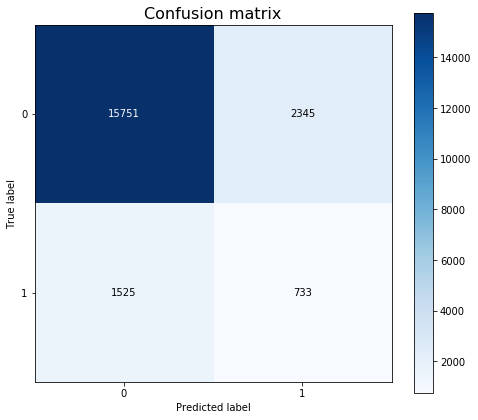

In [24]:
# Plotting the Confusion Matrix in a more visually-pleasing way 
skplt.metrics.plot_confusion_matrix(Y_test, y_pred, normalize = False, figsize=(8, 7))
plt.title("Confusion matrix", fontsize = 16)
plt.ylim(1.5, -0.5)
plt.show()

In [25]:
# Print out the Classification Report, which shows the metrics for each target class 
# Then printing out the overall Accuracy, Precision, Recall, and F1 score for the 
# validation class 

print(classification_report(Y_test, y_pred))

accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0)) 
print("\n")

precision = precision_score(Y_test, y_pred, average = 'macro') 
print("Precision: %.2f%%" % (precision * 100.0)) 
print("\n")

F1_score = f1_score(Y_test, y_pred, average = 'macro')
print("F1 Score: %.2f%%" % (F1_score * 100))
print("\n")

recall = recall_score(Y_test, y_pred, average = 'macro')
print("Recall: %.2f%%" % (recall * 100))
print("\n")

              precision    recall  f1-score   support

           0       0.91      0.87      0.89     18096
           1       0.24      0.32      0.27      2258

    accuracy                           0.81     20354
   macro avg       0.57      0.60      0.58     20354
weighted avg       0.84      0.81      0.82     20354

Accuracy: 80.99%


Precision: 57.49%


F1 Score: 58.27%


Recall: 59.75%




#### From the above we see that this model/algorithm does not perform 'super' well with identifying patients that will be readmitted, as the precision, recall, and f1-score for the 1 class are not close to 1. Clearly this is a difficult problem, so we don't expect these values to be as high as the 0 class. 

I will discuss these results more below when comparing to a non-tuned model 

### Want to do Feature Importance to determine which of the features most likely contribute to readmittance - "we can tell doctors what to look for most when worrying about this readmittance" 

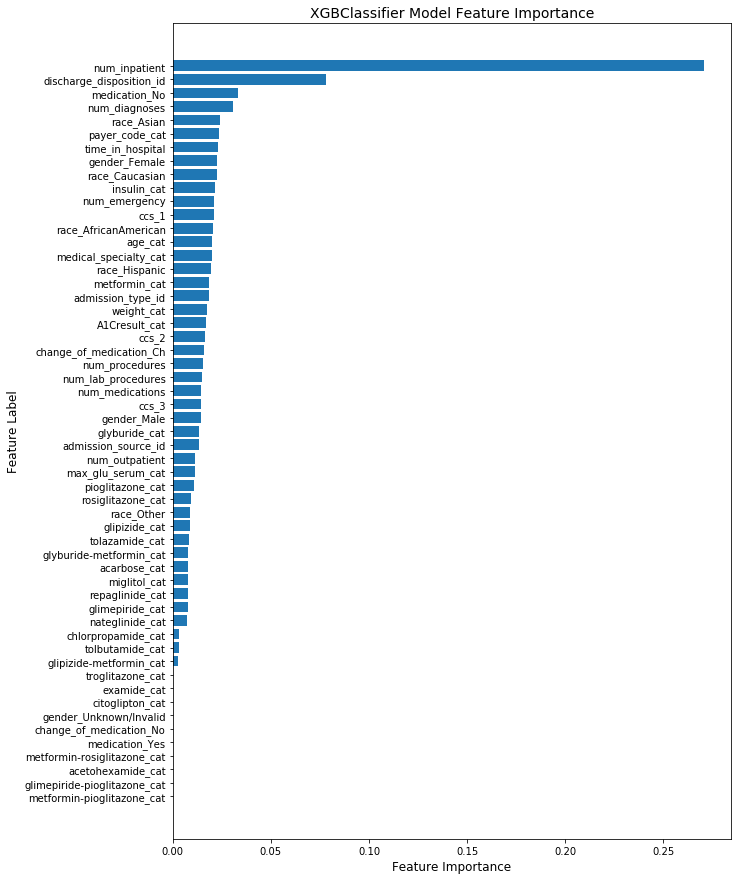

In [26]:
feats = clf_mod.feature_importances_

sorted_idx = feats.argsort()

plt.figure(figsize = (10, 15))
plt.barh(X_train.columns[sorted_idx], feats[sorted_idx])
plt.title("XGBClassifier Model Feature Importance", size = 14)
plt.xlabel("Feature Importance", size = 12)
plt.ylabel("Feature Label", size = 12)
plt.show()

In [27]:
# Looking at the actual feature importance values

feats[sorted_idx]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00282044, 0.0032712 , 0.00338877, 0.00751933, 0.00757116,
       0.00757394, 0.00782724, 0.00783394, 0.00792773, 0.00817352,
       0.00858429, 0.00880762, 0.00924474, 0.01060161, 0.01119777,
       0.01132828, 0.0131756 , 0.01359033, 0.01436682, 0.01441687,
       0.01451944, 0.01475618, 0.01556641, 0.0157703 , 0.01620997,
       0.01696487, 0.01727344, 0.01851299, 0.01854549, 0.01932554,
       0.01984636, 0.01999797, 0.02056246, 0.02094701, 0.02099562,
       0.0214525 , 0.02243857, 0.02282306, 0.02307635, 0.02380796,
       0.02400156, 0.03090126, 0.03343721, 0.07828295, 0.27076334],
      dtype=float32)

##### Above we see that we have 12 features with feature importances (weights) of zero, meaning that these features do not contribute to building the model. 
If I had more time I would identify these features (can easily tell by the graph), look at the features (.info or .describe) in detail to get a better understanding of their data and then make a decision on whether to take said feature out of the DataFrame (note: keeping features such as these is more of a problem with a much larger dataset)

### For comparison, I have trained an XGBClassifier model below without any hyperparameter tuning, just to look at the resultant metrics

In [28]:
model = XGBClassifier()
model.fit(X_train, Y_train)
Ypred = model.predict(X_test)
cm = confusion_matrix(Y_test, Ypred)
cm

array([[18089,     7],
       [ 2241,    17]])

In [29]:
# Print out the Classification Report, which shows the metrics for each target class 
# Then printing out the overall Accuracy, Precision, Recall, and F1 score for the 
# validation class 

print(classification_report(Y_test, Ypred))

accuracy = accuracy_score(Y_test, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0)) 
print("\n")

precision = precision_score(Y_test, Ypred, average = 'macro') 
print("Precision: %.2f%%" % (precision * 100.0)) 
print("\n")

F1_score = f1_score(Y_test, Ypred, average = 'macro')
print("F1 Score: %.2f%%" % (F1_score * 100))
print("\n")

recall = recall_score(Y_test, Ypred, average = 'macro')
print("Recall: %.2f%%" % (recall * 100))
print("\n")

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18096
           1       0.71      0.01      0.01      2258

    accuracy                           0.89     20354
   macro avg       0.80      0.50      0.48     20354
weighted avg       0.87      0.89      0.84     20354

Accuracy: 88.96%


Precision: 79.91%


F1 Score: 47.82%


Recall: 50.36%




#### As we can see, although the overall accuracy is better (expected because there is an imbalance and we are not weighting the minority class higher here) this model is not actually performing better when we try to identify patients that will be readmitted. Although the model we have settled on previously (tuned) does not have 'fantastic' metric scores, the Recall and F1-Scores are higher, both overall and especially for the 1 class. 

##### So even though the model we have settled on previously (tuned) has a decrease in accuracy and precision, the metrics increase significantly when we look at the power of the model identifying patients that will be readmitted. In every model there will be trade-offs such as this, and here we want to focus on F1 and Recall more than Accuracy and Precision and identifying patients that will be readmitted. 

### Creating new model without some features, based on Feature Importance information

In [30]:
y.head()

,readmitted
0,0
1,0
2,0
3,0
4,1


In [31]:
new_df.shape

(101766, 55)

In [32]:
new_df.drop(['change_of_medication_No', 'medication_Yes', 'metformin-rosiglitazone_cat', 
             'examide_cat', 'citoglipton_cat', 'gender_Unknown/Invalid', 'acetohexamide_cat', 
             'troglitazone_cat', 'glimepiride-pioglitazone_cat', 'metformin-pioglitazone_cat'],
            axis = 1, inplace = True) 

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(new_df, y, train_size = 0.8)

In [34]:
# model fitting with the best parameters 

from xgboost import XGBClassifier

clf_mod = XGBClassifier(scale_pos_weight = 5, learning_rate = 0.1, max_depth = 3, n_estimators = 600, early_stopping_rounds = 10, n_jobs = -1)
clf_mod.fit(X_train, Y_train)
y_pred = clf_mod.predict(X_test)
con_mat_now = confusion_matrix(Y_test, y_pred) 

In [35]:
print('Confusion Matrix: ', '\n', con_mat_now)

Confusion Matrix:  
 [[15852  2200]
 [ 1549   753]]


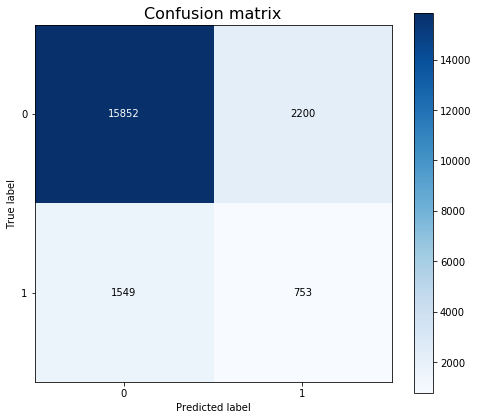

In [36]:
# Plotting the Confusion Matrix in a more visually-pleasing way 
skplt.metrics.plot_confusion_matrix(Y_test, y_pred, normalize = False, figsize=(8, 7))
plt.title("Confusion matrix", fontsize = 16)
plt.ylim(1.5, -0.5)
plt.show()

In [37]:
# Print out the Classification Report, which shows the metrics for each target class 
# Then printing out the overall Accuracy, Precision, Recall, and F1 score for the 
# validation class 

print(classification_report(Y_test, y_pred))

accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0)) 
print("\n")

precision = precision_score(Y_test, y_pred, average = 'macro') 
print("Precision: %.2f%%" % (precision * 100.0)) 
print("\n")

F1_score = f1_score(Y_test, y_pred, average = 'macro')
print("F1 Score: %.2f%%" % (F1_score * 100))
print("\n")

recall = recall_score(Y_test, y_pred, average = 'macro')
print("Recall: %.2f%%" % (recall * 100))
print("\n")

              precision    recall  f1-score   support

           0       0.91      0.88      0.89     18052
           1       0.25      0.33      0.29      2302

    accuracy                           0.82     20354
   macro avg       0.58      0.60      0.59     20354
weighted avg       0.84      0.82      0.83     20354

Accuracy: 81.58%


Precision: 58.30%


F1 Score: 59.04%


Recall: 60.26%




### Now that I have taken out the features that have a feature importance/weight of 0 and run the model using the same hyperparameter-tuning values as above, the Accuracy, Precision, F1 Score, and Recall have improved, but only barely. 

This makes a lot of sense since the feature importance/weight is 0 so the features aren't contributing, so the metrics shouldn't change when taken out. This, however, can cut down the training time for the model. 

### Now we will cull the patients whose discharge code is listed as 'expired' since they have no chance at being readmitted. Since they technically have zero chance of being readmitted their 'readmitted' value is 0, thus skewing that class. We will take them out now and re-train the model to hopefully improve the performance. 

I'm going to re-load the data and do all the feature engineering again so that I make sure the dataframes are the correct, matching size

In [38]:
data = pd.read_csv("data.csv")

one_hot_cols = ['race', 'gender', 'change_of_medication', 'medication']
data = pd.get_dummies(data, columns = one_hot_cols)

ICD = pd.read_csv("icd_to_ccs_mapping.csv")
ICD = ICD[['icd', 'ccs']]

ICD = ICD.rename(columns = {'ccs': 'ccs_1'})
new_df = pd.merge(data, ICD, left_on = 'diag_1', right_on = 'icd', how = 'left')

ICD = ICD.rename(columns = {'ccs_1': 'ccs_2'})
new_df = pd.merge(new_df, ICD, left_on = 'diag_2', right_on = 'icd', how = 'left')

ICD = ICD.rename(columns = {'ccs_2': 'ccs_3'})
new_df = pd.merge(new_df, ICD, left_on = 'diag_3', right_on = 'icd', how = 'left')

new_df = new_df.drop(columns = ['diag_1', 'diag_2', 'diag_3', 'icd_x', 'icd_y', 'icd'])
print(new_df.shape)

new_df["age"] = new_df["age"].astype('category')
new_df["age_cat"] = new_df["age"].cat.codes

new_df["weight"] = new_df["weight"].astype('category')
new_df["weight_cat"] = new_df["weight"].cat.codes

new_df["payer_code"] = new_df["payer_code"].astype('category')
new_df["payer_code_cat"] = new_df["payer_code"].cat.codes

new_df["medical_specialty"] = new_df["medical_specialty"].astype('category')
new_df["medical_specialty_cat"] = new_df["medical_specialty"].cat.codes

new_df["max_glu_serum"] = new_df["max_glu_serum"].astype('category')
new_df["max_glu_serum_cat"] = new_df["max_glu_serum"].cat.codes

new_df["A1Cresult"] = new_df["A1Cresult"].astype('category')
new_df["A1Cresult_cat"] = new_df["A1Cresult"].cat.codes

new_df["metformin"] = new_df["metformin"].astype('category')
new_df["metformin_cat"] = new_df["metformin"].cat.codes

new_df["repaglinide"] = new_df["repaglinide"].astype('category')
new_df["repaglinide_cat"] = new_df["repaglinide"].cat.codes

new_df["nateglinide"] = new_df["nateglinide"].astype('category')
new_df["nateglinide_cat"] = new_df["nateglinide"].cat.codes

new_df["chlorpropamide"] = new_df["chlorpropamide"].astype('category')
new_df["chlorpropamide_cat"] = new_df["chlorpropamide"].cat.codes

new_df["glimepiride"] = new_df["glimepiride"].astype('category')
new_df["glimepiride_cat"] = new_df["glimepiride"].cat.codes

new_df["acetohexamide"] = new_df["acetohexamide"].astype('category')
new_df["acetohexamide_cat"] = new_df["acetohexamide"].cat.codes

new_df["glipizide"] = new_df["glipizide"].astype('category')
new_df["glipizide_cat"] = new_df["glipizide"].cat.codes

new_df["glyburide"] = new_df["glyburide"].astype('category')
new_df["glyburide_cat"] = new_df["glyburide"].cat.codes

new_df["tolbutamide"] = new_df["tolbutamide"].astype('category')
new_df["tolbutamide_cat"] = new_df["tolbutamide"].cat.codes

new_df["pioglitazone"] = new_df["pioglitazone"].astype('category')
new_df["pioglitazone_cat"] = new_df["pioglitazone"].cat.codes

new_df["rosiglitazone"] = new_df["rosiglitazone"].astype('category')
new_df["rosiglitazone_cat"] = new_df["rosiglitazone"].cat.codes

new_df["acarbose"] = new_df["acarbose"].astype('category')
new_df["acarbose_cat"] = new_df["acarbose"].cat.codes

new_df["miglitol"] = new_df["miglitol"].astype('category')
new_df["miglitol_cat"] = new_df["miglitol"].cat.codes

new_df["troglitazone"] = new_df["troglitazone"].astype('category')
new_df["troglitazone_cat"] = new_df["troglitazone"].cat.codes

new_df["tolazamide"] = new_df["tolazamide"].astype('category')
new_df["tolazamide_cat"] = new_df["tolazamide"].cat.codes

new_df["examide"] = new_df["examide"].astype('category')
new_df["examide_cat"] = new_df["examide"].cat.codes

new_df["citoglipton"] = new_df["citoglipton"].astype('category')
new_df["citoglipton_cat"] = new_df["citoglipton"].cat.codes

new_df["insulin"] = new_df["insulin"].astype('category')
new_df["insulin_cat"] = new_df["insulin"].cat.codes

new_df["glyburide-metformin"] = new_df["glyburide-metformin"].astype('category')
new_df["glyburide-metformin_cat"] = new_df["glyburide-metformin"].cat.codes

new_df["glipizide-metformin"] = new_df["glipizide-metformin"].astype('category')
new_df["glipizide-metformin_cat"] = new_df["glipizide-metformin"].cat.codes

new_df["glimepiride-pioglitazone"] = new_df["glimepiride-pioglitazone"].astype('category')
new_df["glimepiride-pioglitazone_cat"] = new_df["glimepiride-pioglitazone"].cat.codes

new_df["metformin-rosiglitazone"] = new_df["metformin-rosiglitazone"].astype('category')
new_df["metformin-rosiglitazone_cat"] = new_df["metformin-rosiglitazone"].cat.codes

new_df["metformin-pioglitazone"] = new_df["metformin-pioglitazone"].astype('category')
new_df["metformin-pioglitazone_cat"] = new_df["metformin-pioglitazone"].cat.codes

new_df = new_df.drop(columns = ['age', 'weight', 'payer_code', 'medical_specialty', 
                                'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 
                                'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 
                                'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
                                'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 
                                'tolazamide', 'examide', 'citoglipton', 'insulin', 
                                'glyburide-metformin', 'glipizide-metformin', 
                                'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
                                'metformin-pioglitazone'])

new_df['readmitted'] = new_df['readmitted'].apply(lambda x: 0 if x == 'NO' else 1)

new_df.drop(['change_of_medication_No', 'medication_Yes', 'metformin-rosiglitazone_cat', 
             'examide_cat', 'citoglipton_cat', 'gender_Unknown/Invalid', 'acetohexamide_cat', 
             'troglitazone_cat', 'glimepiride-pioglitazone_cat', 'metformin-pioglitazone_cat'],
            axis = 1, inplace = True) 

new_df = new_df[new_df.discharge_disposition_id != 11]
new_df = new_df[new_df.discharge_disposition_id != 19]
new_df = new_df[new_df.discharge_disposition_id != 20]
new_df = new_df[new_df.discharge_disposition_id != 21]

y = new_df[['readmitted']]
new_df.drop(['readmitted', 'patient_ID'], axis = 1, inplace = True)

(101766, 57)


In [39]:
new_df

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,num_outpatient,num_emergency,num_inpatient,num_diagnoses,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,change_of_medication_Ch,medication_No,ccs_1,ccs_2,ccs_3,age_cat,weight_cat,payer_code_cat,medical_specialty_cat,max_glu_serum_cat,A1Cresult_cat,metformin_cat,repaglinide_cat,nateglinide_cat,chlorpropamide_cat,glimepiride_cat,glipizide_cat,glyburide_cat,tolbutamide_cat,pioglitazone_cat,rosiglitazone_cat,acarbose_cat,miglitol_cat,tolazamide_cat,insulin_cat,glyburide-metformin_cat,glipizide-metformin_cat
0,1,6,3,1,33,1,4,0,0,3,4,0,0,1,0,0,1,0,0,1,181.0,181.0,49.0,2,-1,-1,-1,2,2,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0
1,3,18,4,2,48,3,19,0,0,0,9,0,0,1,0,0,1,0,1,0,100.0,6.0,101.0,5,-1,-1,-1,2,2,1,1,1,1,3,1,1,0,1,1,1,1,0,1,1,0
2,6,1,17,2,28,0,7,0,0,0,1,0,0,1,0,0,0,1,1,0,49.0,NaN,NaN,3,-1,-1,11,2,2,1,1,1,1,1,1,1,0,1,1,1,1,0,0,1,0
3,2,1,7,5,40,0,6,0,0,0,4,0,0,1,0,0,0,1,0,0,197.0,199.0,49.0,3,-1,14,18,2,2,2,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0
4,5,3,1,4,35,1,7,2,0,0,9,0,0,1,0,0,1,0,0,0,83.0,211.0,49.0,8,-1,7,-1,2,2,2,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1,6,7,3,30,0,16,1,0,0,9,0,0,1,0,0,1,0,0,0,197.0,6.0,49.0,5,-1,8,11,2,2,2,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0
101762,1,1,1,1,36,0,19,0,0,0,9,0,0,1,0,0,0,1,1,0,102.0,101.0,106.0,6,-1,15,-1,2,1,1,1,1,1,1,1,1,0,1,1,1,1,0,3,1,0
101763,2,1,1,1,42,4,21,0,0,0,9,0,0,1,0,0,1,0,1,0,101.0,158.0,101.0,7,-1,2,-1,2,2,1,1,1,1,1,1,2,0,1,1,1,1,0,3,1,0
101764,1,6,7,5,40,4,14,0,0,0,9,0,0,1,0,0,1,0,0,1,146.0,106.0,101.0,7,-1,7,-1,2,2,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0


In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(new_df, y, train_size = 0.8)

In [41]:
from xgboost import XGBClassifier

clf_mod = XGBClassifier(scale_pos_weight = 5, learning_rate = 0.1, max_depth = 3, n_estimators = 600, early_stopping_rounds = 10, n_jobs = -1)
clf_mod.fit(X_train, Y_train)
y_pred = clf_mod.predict(X_test)
con_mat_now = confusion_matrix(Y_test, y_pred) 

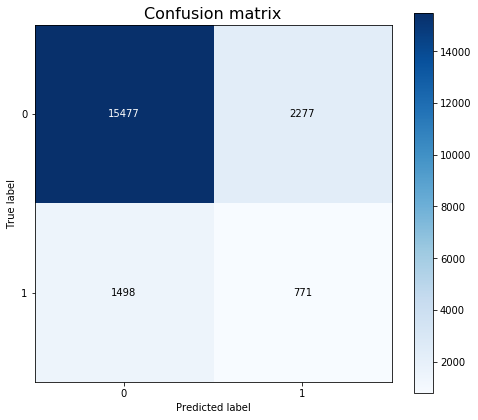

In [42]:
# Plotting the Confusion Matrix in a more visually-pleasing way 
skplt.metrics.plot_confusion_matrix(Y_test, y_pred, normalize = False, figsize=(8, 7))
plt.title("Confusion matrix", fontsize = 16)
plt.ylim(1.5, -0.5)
plt.show()

In [43]:
print(classification_report(Y_test, y_pred))

accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0)) 
print("\n")

precision = precision_score(Y_test, y_pred, average = 'macro') 
print("Precision: %.2f%%" % (precision * 100.0)) 
print("\n")

F1_score = f1_score(Y_test, y_pred, average = 'macro')
print("F1 Score: %.2f%%" % (F1_score * 100))
print("\n")

recall = recall_score(Y_test, y_pred, average = 'macro')
print("Recall: %.2f%%" % (recall * 100))
print("\n")

              precision    recall  f1-score   support

           0       0.91      0.87      0.89     17754
           1       0.25      0.34      0.29      2269

    accuracy                           0.81     20023
   macro avg       0.58      0.61      0.59     20023
weighted avg       0.84      0.81      0.82     20023

Accuracy: 81.15%


Precision: 58.24%


F1 Score: 59.07%


Recall: 60.58%




#### Note that these are the metrics for the previously hyper-parameter trained model before we removed the expired patients and dropped the features that did not contribute to training the model (feature importance value of 0)

0       - 0.91      - 0.87      - 0.89     - 18096

1       - 0.24      - 0.32      - 0.27      - 2258


Accuracy: 80.99%

Precision: 57.49%

F1 Score: 58.27%

Recall: 59.75%

#### We can see that the metrics have slightly increased once we did more feature engineering, so this latest  model we created (hyper-parameter tuning plus extra feature engineering) was the best version!

## In this notebook I have: 
- Loaded the data and did some EDA and feature engineering. 
- Created a model with hyperparameter tuning using GridSearchCV and EarlyStopping (saving the best parameters to use for later versions of the model) and then looked at Feature Importance. 
- Then I created a model without any hyperparameter tuning so that I can compare the difference with and without the tuning. 
- Next, I did more feature engineering by dropping some features to see the difference that made. 
- Finally, I dropped some patients that I thought might be skewing the model creation to see how that affected the performance.
- After all of that I found that the final model I created (hyper-parameter tuning with additional feature engineering) was the best performing model. 

## Next Steps to get better results: 
- Try out different ML Classification algorithms to compare performance 
- Look into using other feature engineering tools (maybe some categorical embeddings, dimensionality reduction, etc.) 
- More 